# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
X_train

,date,station,job,ferie,vacances
index,,,,,
2015-01-01_1J7,2015-01-01,1J7,1,1,1
2015-01-01_O2O,2015-01-01,O2O,1,1,1
2015-01-01_8QR,2015-01-01,8QR,1,1,1
2015-01-01_UMC,2015-01-01,UMC,1,1,1
2015-01-01_FK3,2015-01-01,FK3,1,1,1
...,...,...,...,...,...
2022-12-31_V2P,2022-12-31,V2P,0,0,1
2022-12-31_N9K,2022-12-31,N9K,0,0,1
2022-12-31_P6E,2022-12-31,P6E,0,0,1


In [5]:
X_test

,date,station,job,ferie,vacances
index,,,,,
2023-01-01_1J7,2023-01-01,1J7,0,1,1
2023-01-01_O2O,2023-01-01,O2O,0,1,1
2023-01-01_8QR,2023-01-01,8QR,0,1,1
2023-01-01_L58,2023-01-01,L58,0,1,1
2023-01-01_UMC,2023-01-01,UMC,0,1,1
...,...,...,...,...,...
2023-05-31_N9K,2023-05-31,N9K,1,0,0
2023-05-31_P6E,2023-05-31,P6E,1,0,0
2023-05-31_BDC,2023-05-31,BDC,1,0,0


Text(0.5, 1.0, 'Evolution du nombre de validations par jour')

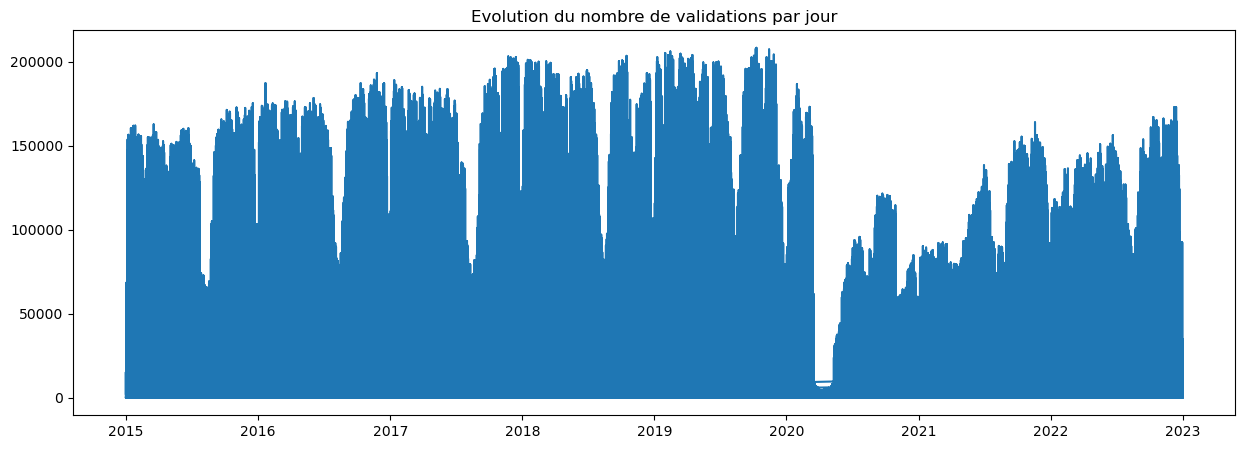

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(X_train['date'], y_train['y'])
plt.title('Evolution du nombre de validations par jour')

Text(0.5, 1.0, 'Station 1J7 pour un mois')

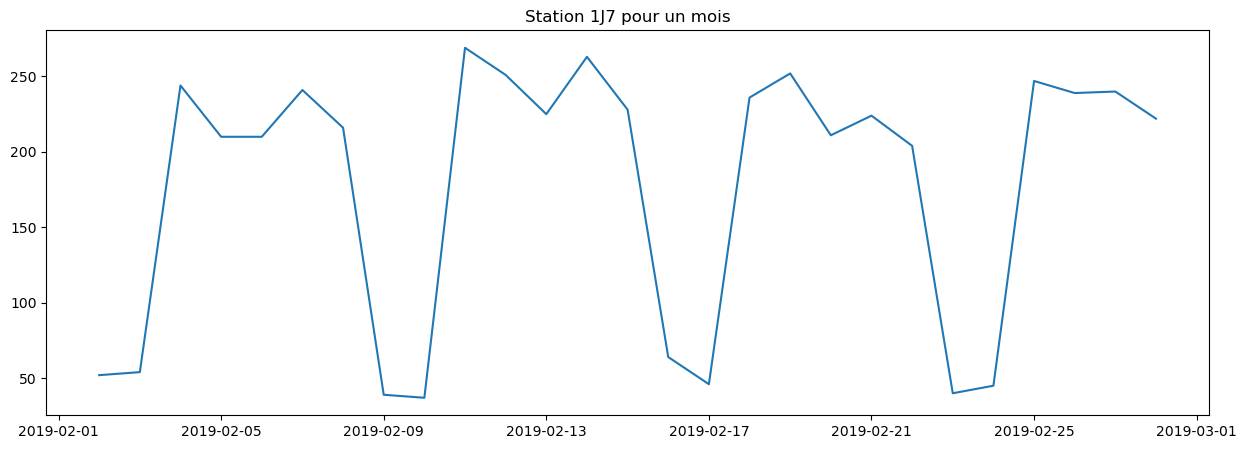

In [7]:
X_plot = X_train.loc[(X_train['date'] > '2019-02-01')
                     & (X_train['date'] < '2019-03-01')
                     & (X_train['station'] == '1J7')]
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_train.loc[X_plot.index, 'y'])
plt.title('Station 1J7 pour un mois')


In [8]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [9]:
def add_lags(df_x, df_y):
    ''' Add lags '''
    target_map = df_y['y'].to_dict()

    df_x['lagDay'] = (
        (df_x.date - pd.DateOffset(days=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)
    
    df_x['lagWeek'] = (
        (df_x.date - pd.DateOffset(days=7))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    '''df_x['lagMonth'] = (
        (df_x.date - pd.DateOffset(months=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagYear'] = (
        (df_x.date - pd.DateOffset(years=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)'''

    return df_x


In [10]:
X_train = create_features(X_train)
X_train = add_lags(X_train, y_train)
X_test = create_features(X_test)
X_test = add_lags(X_test, y_train)

In [11]:
X_train.tail()

,date,station,job,ferie,vacances,day,month,year,dayofweek,lagDay,lagWeek
index,,,,,,,,,,,
2022-12-31_V2P,2022-12-31,V2P,0,0,1,31,12,2022,5,1503.0,1063.0
2022-12-31_N9K,2022-12-31,N9K,0,0,1,31,12,2022,5,760.0,417.0
2022-12-31_P6E,2022-12-31,P6E,0,0,1,31,12,2022,5,112.0,74.0
2022-12-31_BDC,2022-12-31,BDC,0,0,1,31,12,2022,5,70.0,53.0
2022-12-31_W14,2022-12-31,W14,0,0,1,31,12,2022,5,19.0,10.0


<Axes: xlabel='year', ylabel='y'>

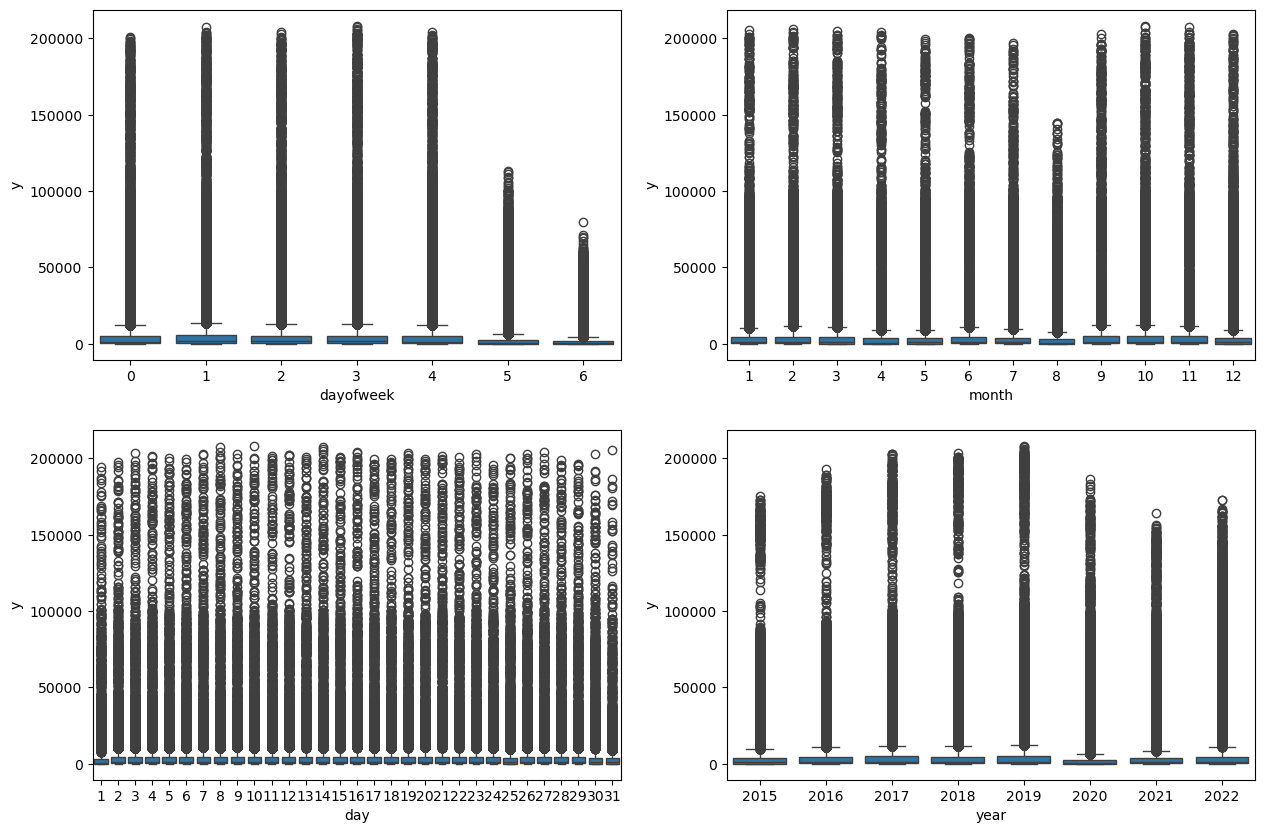

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=X_train.dayofweek, y=y_train.y, ax=ax[0, 0])
sns.boxplot(x=X_train.month, y=y_train.y, ax=ax[0, 1])
sns.boxplot(x=X_train.day, y=y_train.y, ax=ax[1, 0])
sns.boxplot(x=X_train.year, y=y_train.y, ax=ax[1, 1])

In [13]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
#X_train = X_train.drop(columns=['year', 'month', 'day', 'dayofweek'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
#X_test = X_test.drop(columns=['year', 'month', 'day', 'dayofweek'])
X_test['station'] = X_test['station'].astype('category')

In [ ]:
X_train.tail()

In [ ]:
#X_train_ = X_train.dropna()
#y_train_ = y_train.loc[X_train_.index]

In [ ]:
estimator = xgb.XGBRegressor(enable_categorical=True, early_stopping_rounds=50, n_estimators=700, max_depth=10)

param_grid = {
    'learning_rate': [0.1, 0.05],
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv= KFold(n_splits=3, shuffle=True),
    verbose=100,  
    n_jobs=-1,
).fit(X_train_, y_train_, eval_set=[(X_train_, y_train_)], verbose=100)

print("Best params:", grid_search.best_params_)

In [ ]:
for p, i in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f'Score {p}: {i}')

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_, y_train_, eval_set=[(X_train_, y_train_)], verbose=100)

In [14]:
estimator = xgb.XGBRegressor(enable_categorical=True, early_stopping_rounds=50, n_estimators=700, learning_rate=0.1, 
                             max_depth=10, eval_metric='rmse')
estimator.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)
print(estimator.evals_result())

[0]	validation_0-rmse:8750.26131
[100]	validation_0-rmse:804.52892
[200]	validation_0-rmse:643.93882
[300]	validation_0-rmse:550.57992
[400]	validation_0-rmse:489.24400
[500]	validation_0-rmse:439.61343
[600]	validation_0-rmse:403.39427
[699]	validation_0-rmse:373.52409
{'validation_0': OrderedDict({'rmse': [8750.261313783458, 7912.252134605253, 7159.111672955958, 6483.696175409775, 5878.212823510222, 5334.670162075594, 4847.927312194048, 4411.659986931102, 4021.4315303254994, 3673.966322681025, 3363.7679815785164, 3085.956232323667, 2839.6846899982083, 2623.0984887015093, 2429.731616305957, 2257.4235210535235, 2105.871734050975, 1974.2311060740387, 1858.4546130835529, 1757.2857743618074, 1667.9127307728072, 1590.4040896796062, 1518.5313570307055, 1457.5619033768558, 1404.1506252212846, 1359.0335283535937, 1317.6072503948342, 1282.139211323363, 1250.5210344131722, 1220.2957916778314, 1195.2508106327646, 1173.0031445820703, 1154.024519719846, 1135.0873175611914, 1118.6319275854783, 1103

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

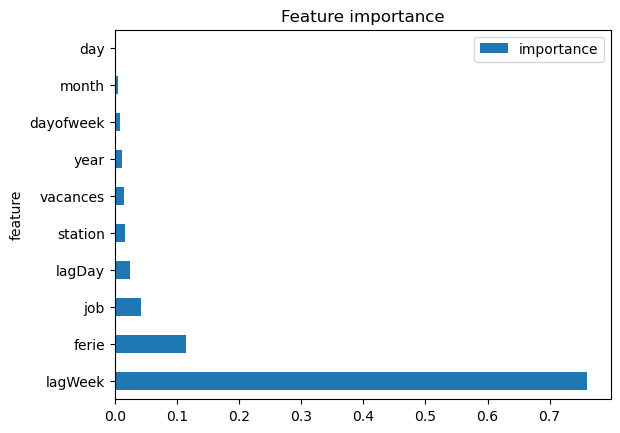

In [16]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': estimator.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [18]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred_vals = estimator.predict(X_test)
y_pred['y'] = np.clip(y_pred_vals, 0, None).astype(int) # Clip negative values to 0
y_pred.to_csv(file_path + 'y_pred.csv')

In [20]:
#save model
estimator.save_model(file_path + 'model_xgb_n700_best.json')

n_estimators=700, max_depth=10, subsample=1, learning_rate = 0.1

Score: 104.05024559560385